In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

# Get Data

# OMG-USD

In [5]:
df=pd.read_csv('CC_daily_data.csv').dropna()
dfclose = df[df['ticker']=='OMG-USD'].set_index(['date'])['close'].to_frame()
dfclose = dfclose[~dfclose.index.duplicated(keep = 'first')]
dfclose

,close
date,
2017-07-13,0.582480
2017-07-14,0.433351
2017-07-15,0.384906
2017-07-16,0.582786
2017-07-17,0.759819
...,...
2020-12-26,2.529716
2020-12-27,2.604007
2020-12-28,2.650469


In [6]:
dfreturn = (np.log(dfclose/dfclose.shift())
            .dropna()
            .rename(columns = {'close':'return'}))
dfreturn

,return
date,
2017-07-14,-0.295747
2017-07-15,-0.118549
2017-07-16,0.414821
2017-07-17,0.265260
2017-07-18,-0.263332
...,...
2020-12-26,-0.020800
2020-12-27,0.028944
2020-12-28,0.017685


In [7]:
results_path = Path('results', 'univariate_LSTM')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Predicting Future Price:

# Preprocessing

In [8]:
scaler = MinMaxScaler()
dfclose_scaled = pd.Series(scaler.fit_transform(dfclose).squeeze(),index =dfclose.index)
dfclose_scaled.describe()

count    1259.000000
mean        0.167958
std         0.197146
min         0.000000
25%         0.033794
50%         0.073910
75%         0.271240
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

We will generate sequences of 90 trading days, approximately 3 months, and use a single LSTM layer with 10 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

In [9]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [10]:
window_size = 90

In [11]:
X,y = create_univariate_rnn_data(dfclose_scaled, window_size)

In [12]:
X.shape

(1169, 90)

# Train-test split

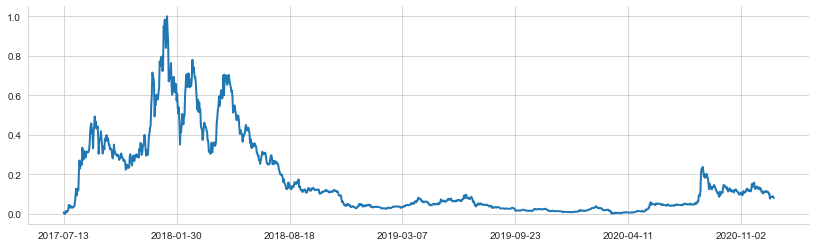

In [13]:
ax = dfclose_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [14]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [15]:
n_obs, window_size, n_features = X_train.shape

In [16]:
y_train.shape

(809,)

# Define Model Architechture

In [17]:
rnn_price = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [18]:
rnn_price.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [19]:
optimizer = keras.optimizers.RMSprop(lr=.001, rho = .9, epsilon = 1e-08, decay = .0)
rnn_price.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [20]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,verbose=1,monitor='val_loss',save_best_only=True)

In [21]:
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 20, restore_best_weights = True)

In [22]:
lstm_training_price = rnn_price.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
41/41 [==============================] - 4s 43ms/step - loss: 0.1410 - val_loss: 0.0119

Epoch 00001: val_loss improved from inf to 0.01186, saving model to results/univariate_LSTM\rnn.h5
Epoch 2/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0253 - val_loss: 0.0026

Epoch 00002: val_loss improved from 0.01186 to 0.00262, saving model to results/univariate_LSTM\rnn.h5
Epoch 3/150
41/41 [==============================] - 0s 12ms/step - loss: 0.0052 - val_loss: 7.2286e-04

Epoch 00003: val_loss improved from 0.00262 to 0.00072, saving model to results/univariate_LSTM\rnn.h5
Epoch 4/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 5.9858e-04

Epoch 00004: val_loss improved from 0.00072 to 0.00060, saving model to results/univariate_LSTM\rnn.h5
Epoch 5/150
41/41 [==============================] - 0s 12ms/step - loss: 0.0034 - val_loss: 5.6047e-04

Epoch 00005: val_loss improved from 0.00060 to 0.00056, saving model to res

41/41 [==============================] - 0s 11ms/step - loss: 7.5533e-04 - val_loss: 2.0825e-04

Epoch 00044: val_loss did not improve from 0.00015
Epoch 45/150
41/41 [==============================] - 0s 11ms/step - loss: 7.5284e-04 - val_loss: 1.5125e-04

Epoch 00045: val_loss did not improve from 0.00015
Epoch 46/150
41/41 [==============================] - 0s 11ms/step - loss: 8.4525e-04 - val_loss: 1.4839e-04

Epoch 00046: val_loss improved from 0.00015 to 0.00015, saving model to results/univariate_LSTM\rnn.h5
Epoch 47/150
41/41 [==============================] - 0s 11ms/step - loss: 9.9212e-04 - val_loss: 2.1308e-04

Epoch 00047: val_loss did not improve from 0.00015
Epoch 48/150
41/41 [==============================] - 0s 11ms/step - loss: 6.5658e-04 - val_loss: 1.3919e-04

Epoch 00048: val_loss improved from 0.00015 to 0.00014, saving model to results/univariate_LSTM\rnn.h5
Epoch 49/150
41/41 [==============================] - 0s 11ms/step - loss: 7.5537e-04 - val_loss: 2.1114

41/41 [==============================] - 0s 11ms/step - loss: 6.9933e-04 - val_loss: 1.0674e-04

Epoch 00091: val_loss improved from 0.00011 to 0.00011, saving model to results/univariate_LSTM\rnn.h5
Epoch 92/150
41/41 [==============================] - 0s 11ms/step - loss: 5.6654e-04 - val_loss: 1.1090e-04

Epoch 00092: val_loss did not improve from 0.00011
Epoch 93/150
41/41 [==============================] - 0s 11ms/step - loss: 7.0586e-04 - val_loss: 1.1454e-04

Epoch 00093: val_loss did not improve from 0.00011
Epoch 94/150
41/41 [==============================] - 0s 11ms/step - loss: 6.1922e-04 - val_loss: 1.7646e-04

Epoch 00094: val_loss did not improve from 0.00011
Epoch 95/150
41/41 [==============================] - 0s 11ms/step - loss: 6.4278e-04 - val_loss: 1.0417e-04

Epoch 00095: val_loss improved from 0.00011 to 0.00010, saving model to results/univariate_LSTM\rnn.h5
Epoch 96/150
41/41 [==============================] - 0s 11ms/step - loss: 6.3699e-04 - val_loss: 1.7901

41/41 [==============================] - 0s 11ms/step - loss: 6.2958e-04 - val_loss: 1.2871e-04

Epoch 00138: val_loss did not improve from 0.00009
Epoch 139/150
41/41 [==============================] - 0s 11ms/step - loss: 5.3644e-04 - val_loss: 9.4618e-05

Epoch 00139: val_loss did not improve from 0.00009
Epoch 140/150
41/41 [==============================] - 0s 11ms/step - loss: 6.6657e-04 - val_loss: 1.0726e-04

Epoch 00140: val_loss did not improve from 0.00009
Epoch 141/150
41/41 [==============================] - 0s 11ms/step - loss: 6.4662e-04 - val_loss: 1.0079e-04

Epoch 00141: val_loss did not improve from 0.00009
Epoch 142/150
41/41 [==============================] - 0s 11ms/step - loss: 6.3859e-04 - val_loss: 1.0045e-04

Epoch 00142: val_loss did not improve from 0.00009
Epoch 143/150
41/41 [==============================] - 0s 11ms/step - loss: 6.9110e-04 - val_loss: 1.4419e-04

Epoch 00143: val_loss did not improve from 0.00009
Epoch 144/150
41/41 [=====================

# Evaluate model performance

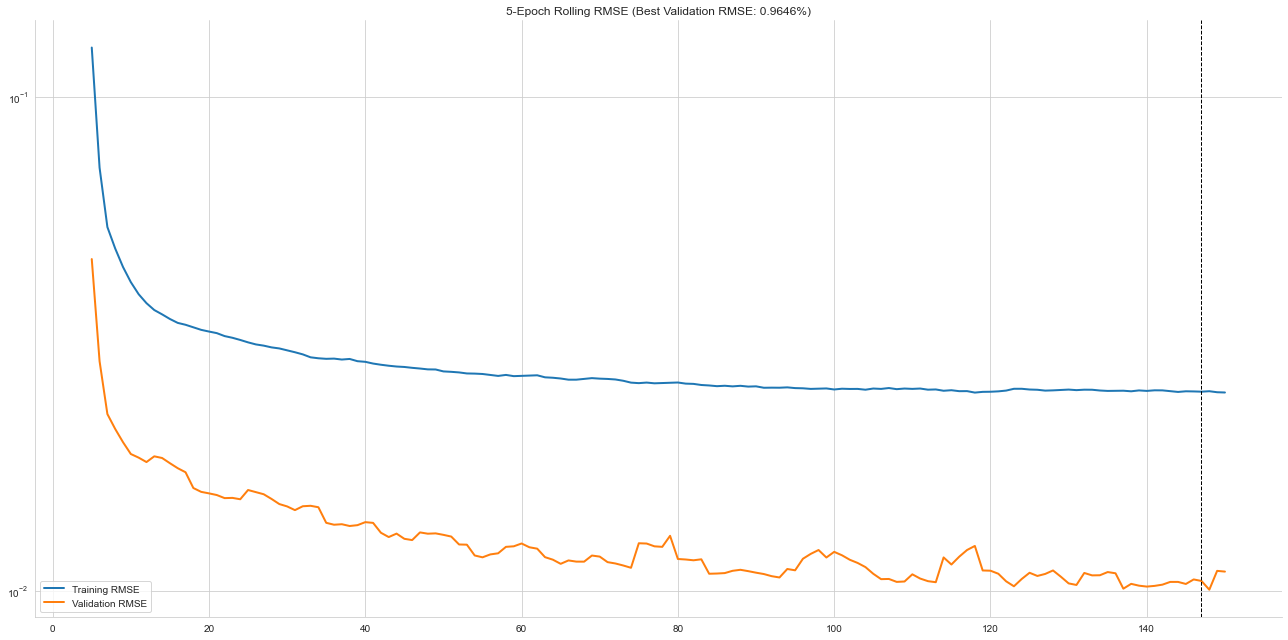

In [23]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_price.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [24]:
train_rmse_scaled = np.sqrt(rnn_price.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_price.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0248 | Test RMSE: 0.0097


In [25]:
train_predict_scaled = rnn_price.predict(X_train)
test_predict_scaled = rnn_price.predict(X_test)

In [26]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9967 | Test IC: 0.9872


# Rescale predictions

In [27]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict =  pd.Series(scaler.inverse_transform(test_predict_scaled) .squeeze(), index=y_test.index)

In [28]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [29]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

Train RMSE: 0.63 | Test RMSE: 0.25


In [30]:
dfclose['Train Predictions'] = train_predict
dfclose['Test Predictions'] = test_predict
dfclose = dfclose.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [31]:
dfclose

,close,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-07-13,0.582480,NaN,NaN,NaN,NaN
2017-07-14,0.433351,NaN,NaN,NaN,NaN
2017-07-15,0.384906,NaN,NaN,NaN,NaN
2017-07-16,0.582786,NaN,NaN,NaN,NaN
2017-07-17,0.759819,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,2.529716,NaN,2.515153,2.515153,Test
2020-12-27,2.604007,NaN,2.495146,2.495146,Test
2020-12-28,2.650469,NaN,2.534472,2.534472,Test


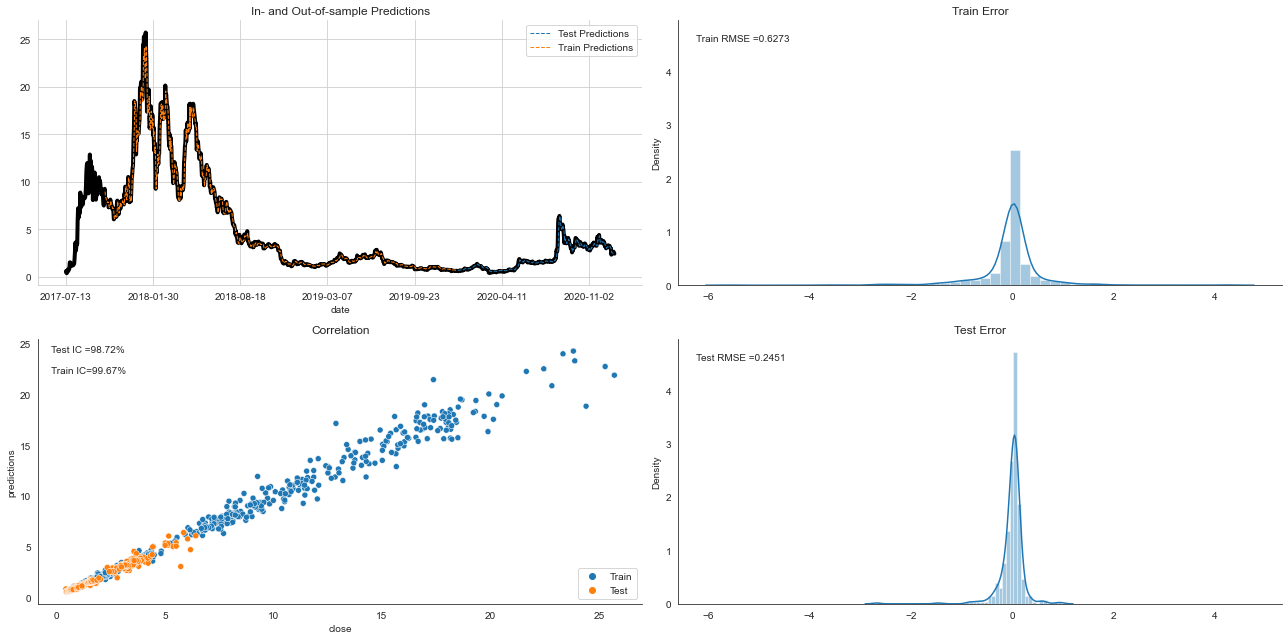

In [32]:
fig=plt.figure(figsize=(18,9))
ax1 = plt.subplot(221)

dfclose.loc['2017':, 'close'].plot(lw=4, ax=ax1, c='k')
dfclose.loc['2017':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='close', y='predictions', data=dfclose, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
# fig.savefig(results_path / 'rnn_cc_regression', dpi=300);

In [33]:
model_test = dfclose.copy()
ar = np.log(model_test['close']/model_test['close'].shift()).fillna(0)
pr = np.log(model_test['predictions'] / model_test['close'].shift()).fillna(0)
tmp = ar*pr[-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.70


# Predicting Future Returns:

# Preprocessing

In [34]:
scaler = MinMaxScaler()
dfreturn_scaled = pd.Series(scaler.fit_transform(dfreturn).squeeze(),index =dfreturn.index)
dfreturn_scaled.describe()

count    1258.000000
mean        0.505543
std         0.070120
min         0.000000
25%         0.474584
50%         0.502778
75%         0.534419
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

In [35]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [36]:
window_size = 90

In [37]:
X,y = create_univariate_rnn_data(dfreturn_scaled, window_size)

In [38]:
X.shape

(1168, 90)

# Train-test split

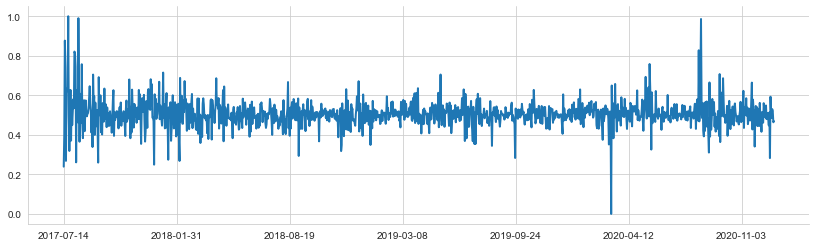

In [39]:
ax = dfreturn_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [40]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [41]:
n_obs, window_size, n_features = X_train.shape

In [42]:
y_train.shape

(808,)

# Define Model Architechture

In [43]:
rnn_return = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [44]:
rnn_return.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [45]:
rnn_return.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [46]:
lstm_training_return = rnn_return.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
41/41 [==============================] - 3s 20ms/step - loss: 0.5035 - val_loss: 0.0798

Epoch 00001: val_loss did not improve from 0.00009
Epoch 2/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0301 - val_loss: 0.0050

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0058

Epoch 00003: val_loss did not improve from 0.00009
Epoch 4/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0052

Epoch 00004: val_loss did not improve from 0.00009
Epoch 5/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0057

Epoch 00005: val_loss did not improve from 0.00009
Epoch 6/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0054

Epoch 00006: val_loss did not improve from 0.00009
Epoch 7/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0036 - val_l


Epoch 00054: val_loss did not improve from 0.00009
Epoch 55/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0055

Epoch 00055: val_loss did not improve from 0.00009
Epoch 56/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0050

Epoch 00056: val_loss did not improve from 0.00009
Epoch 57/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0056

Epoch 00057: val_loss did not improve from 0.00009
Epoch 58/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0050

Epoch 00058: val_loss did not improve from 0.00009
Epoch 59/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0032 - val_loss: 0.0053

Epoch 00059: val_loss did not improve from 0.00009
Epoch 60/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0049

Epoch 00060: val_loss did not improve from 0.00009
Epoch 61/150
41/41 [==========

41/41 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0049

Epoch 00108: val_loss did not improve from 0.00009
Epoch 109/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0031 - val_loss: 0.0057

Epoch 00109: val_loss did not improve from 0.00009
Epoch 110/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0035 - val_loss: 0.0051

Epoch 00110: val_loss did not improve from 0.00009
Epoch 111/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0050

Epoch 00111: val_loss did not improve from 0.00009
Epoch 112/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0033 - val_loss: 0.0049

Epoch 00112: val_loss did not improve from 0.00009
Epoch 113/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0034 - val_loss: 0.0049

Epoch 00113: val_loss did not improve from 0.00009
Epoch 114/150
41/41 [==============================] - 0s 11ms/step - loss: 0.0031 - val_l

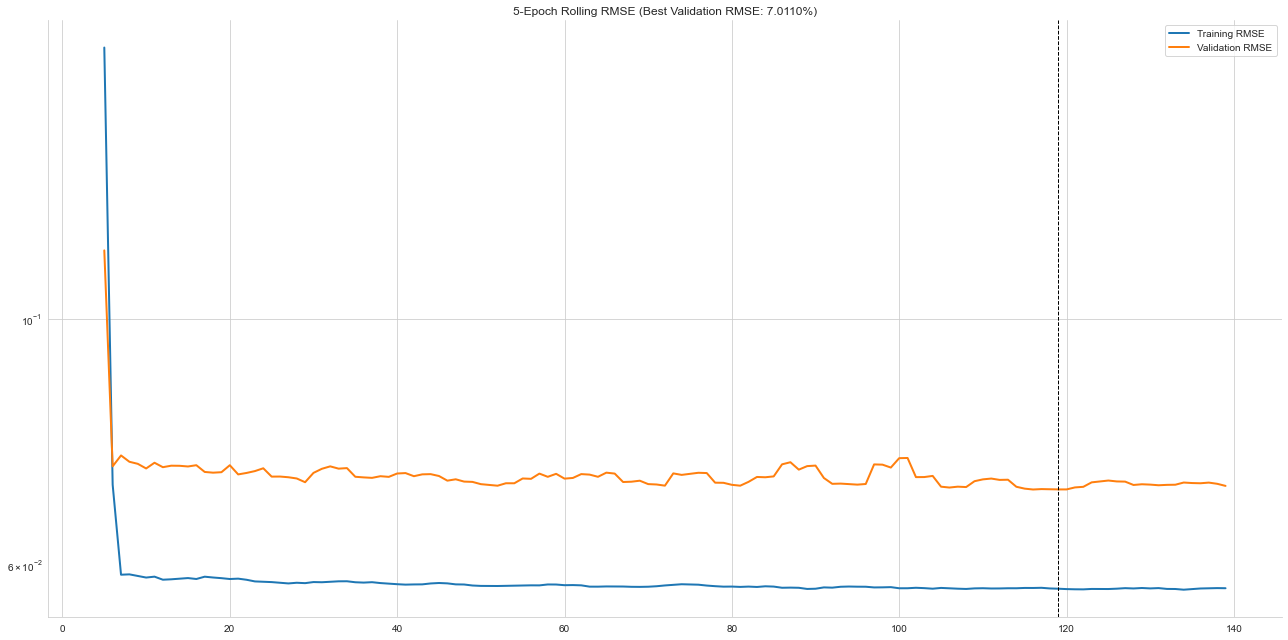

In [47]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_return.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [48]:
train_rmse_scaled = np.sqrt(rnn_return.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_return.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0567 | Test RMSE: 0.0701


In [49]:
train_predict_scaled = rnn_return.predict(X_train)
test_predict_scaled = rnn_return.predict(X_test)

In [50]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.0374 | Test IC: 0.0738


# Rescale predictions

In [51]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [52]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [53]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 0.06 | Test RMSE: 0.08'

In [54]:
dfreturn['Train Predictions'] = train_predict
dfreturn['Test Predictions'] = test_predict
dfreturn = dfreturn.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [55]:
dfreturn

,return,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-07-14,-0.295747,NaN,NaN,NaN,NaN
2017-07-15,-0.118549,NaN,NaN,NaN,NaN
2017-07-16,0.414821,NaN,NaN,NaN,NaN
2017-07-17,0.265260,NaN,NaN,NaN,NaN
2017-07-18,-0.263332,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,-0.020800,NaN,-0.003542,-0.003542,Test
2020-12-27,0.028944,NaN,-0.002180,-0.002180,Test
2020-12-28,0.017685,NaN,-0.003198,-0.003198,Test


In [56]:
model_test = dfreturn.copy().fillna(0)
tmp = model_test['return']*model_test['predictions'][-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.50


# QUTM-USD

In [57]:
df=pd.read_csv('CC_daily_data.csv').dropna()
dfclose = df[df['ticker']=='QTUM-USD'].set_index(['date'])['close'].to_frame()
dfclose = dfclose[~dfclose.index.duplicated(keep = 'first')]
dfclose

,close
date,
2017-05-23,6.190530
2017-05-24,4.656620
2017-05-25,4.099790
2017-05-26,4.533650
2017-05-27,4.621810
...,...
2020-12-26,2.263639
2020-12-27,2.272775
2020-12-28,2.378930


In [58]:
dfreturn = (np.log(dfclose/dfclose.shift())
            .dropna()
            .rename(columns = {'close':'return'}))
dfreturn

,return
date,
2017-05-24,-0.284731
2017-05-25,-0.127354
2017-05-26,0.100592
2017-05-27,0.019259
2017-05-28,-0.003694
...,...
2020-12-26,-0.013039
2020-12-27,0.004028
2020-12-28,0.045649


In [59]:
results_path = Path('results', 'univariate_LSTM')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Predicting Future Price:

# Preprocessing

In [60]:
scaler = MinMaxScaler()
dfclose_scaled = pd.Series(scaler.fit_transform(dfclose).squeeze(),index =dfclose.index)
dfclose_scaled.describe()

count    1310.000000
mean        0.069901
std         0.114721
min         0.000000
25%         0.011272
50%         0.020041
75%         0.096886
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

We will generate sequences of 90 trading days, approximately 3 months, and use a single LSTM layer with 10 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

In [61]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [62]:
window_size = 90

In [63]:
X,y = create_univariate_rnn_data(dfclose_scaled, window_size)

In [64]:
X.shape

(1220, 90)

# Train-test split

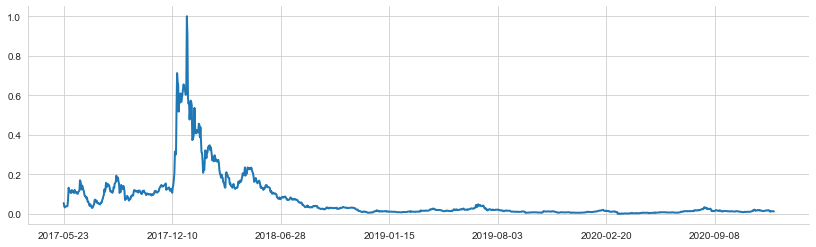

In [65]:
ax = dfclose_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [66]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [67]:
n_obs, window_size, n_features = X_train.shape

In [68]:
y_train.shape

(860,)

# Define Model Architechture

In [69]:
rnn_price = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [70]:
rnn_price.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [71]:
optimizer = keras.optimizers.RMSprop(lr=.001, rho = .9, epsilon = 1e-08, decay = .0)
rnn_price.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [72]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,verbose=1,monitor='val_loss',save_best_only=True)

In [73]:
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 20, restore_best_weights = True)

In [74]:
lstm_training_price = rnn_price.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
43/43 [==============================] - 3s 20ms/step - loss: 0.0122 - val_loss: 4.8692e-04

Epoch 00001: val_loss improved from inf to 0.00049, saving model to results/univariate_LSTM\rnn.h5
Epoch 2/150
43/43 [==============================] - 0s 10ms/step - loss: 0.0038 - val_loss: 1.1860e-05

Epoch 00002: val_loss improved from 0.00049 to 0.00001, saving model to results/univariate_LSTM\rnn.h5
Epoch 3/150
43/43 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 6.7383e-05

Epoch 00003: val_loss did not improve from 0.00001
Epoch 4/150
43/43 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 1.0244e-05

Epoch 00004: val_loss improved from 0.00001 to 0.00001, saving model to results/univariate_LSTM\rnn.h5
Epoch 5/150
43/43 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 9.9289e-06

Epoch 00005: val_loss improved from 0.00001 to 0.00001, saving model to results/univariate_LSTM\rnn.h5
Epoch 6/150
43/4


Epoch 00048: val_loss did not improve from 0.00000
Epoch 49/150
43/43 [==============================] - 0s 10ms/step - loss: 5.2295e-04 - val_loss: 4.7050e-06

Epoch 00049: val_loss did not improve from 0.00000
Epoch 50/150
43/43 [==============================] - 0s 9ms/step - loss: 6.3450e-04 - val_loss: 7.4938e-05

Epoch 00050: val_loss did not improve from 0.00000
Epoch 51/150
43/43 [==============================] - 0s 10ms/step - loss: 4.2130e-04 - val_loss: 5.5385e-05

Epoch 00051: val_loss did not improve from 0.00000
Epoch 52/150
43/43 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 8.8009e-06

Epoch 00052: val_loss did not improve from 0.00000
Epoch 53/150
43/43 [==============================] - 0s 9ms/step - loss: 8.6939e-04 - val_loss: 1.7270e-05

Epoch 00053: val_loss did not improve from 0.00000
Epoch 54/150
43/43 [==============================] - 0s 9ms/step - loss: 5.6459e-04 - val_loss: 2.6502e-05

Epoch 00054: val_loss did not improve fr

# Evaluate model performance

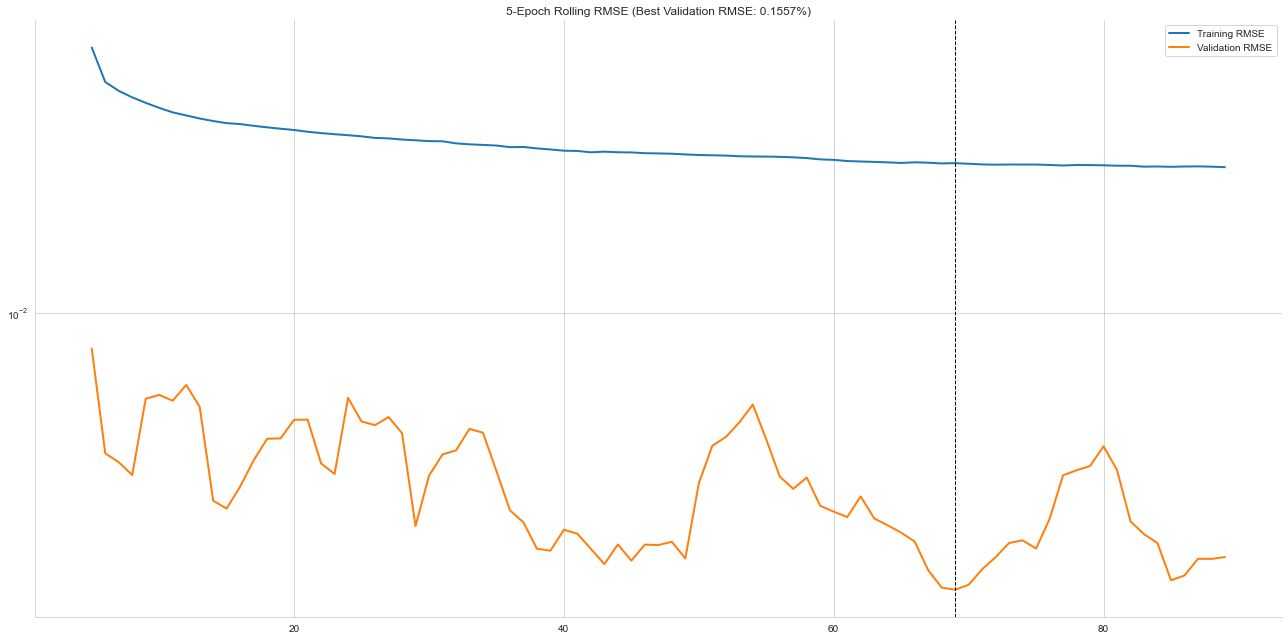

In [75]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_price.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [76]:
train_rmse_scaled = np.sqrt(rnn_price.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_price.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0256 | Test RMSE: 0.0016


In [77]:
train_predict_scaled = rnn_price.predict(X_train)
test_predict_scaled = rnn_price.predict(X_test)

In [78]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9940 | Test IC: 0.9738


# Rescale predictions

In [79]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict =  pd.Series(scaler.inverse_transform(test_predict_scaled) .squeeze(), index=y_test.index)

In [80]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [81]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

Train RMSE: 2.40 | Test RMSE: 0.15


In [82]:
dfclose['Train Predictions'] = train_predict
dfclose['Test Predictions'] = test_predict
dfclose = dfclose.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [83]:
dfclose

,close,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-05-23,6.190530,NaN,NaN,NaN,NaN
2017-05-24,4.656620,NaN,NaN,NaN,NaN
2017-05-25,4.099790,NaN,NaN,NaN,NaN
2017-05-26,4.533650,NaN,NaN,NaN,NaN
2017-05-27,4.621810,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,2.263639,NaN,2.274905,2.274905,Test
2020-12-27,2.272775,NaN,2.245942,2.245942,Test
2020-12-28,2.378930,NaN,2.240146,2.240146,Test


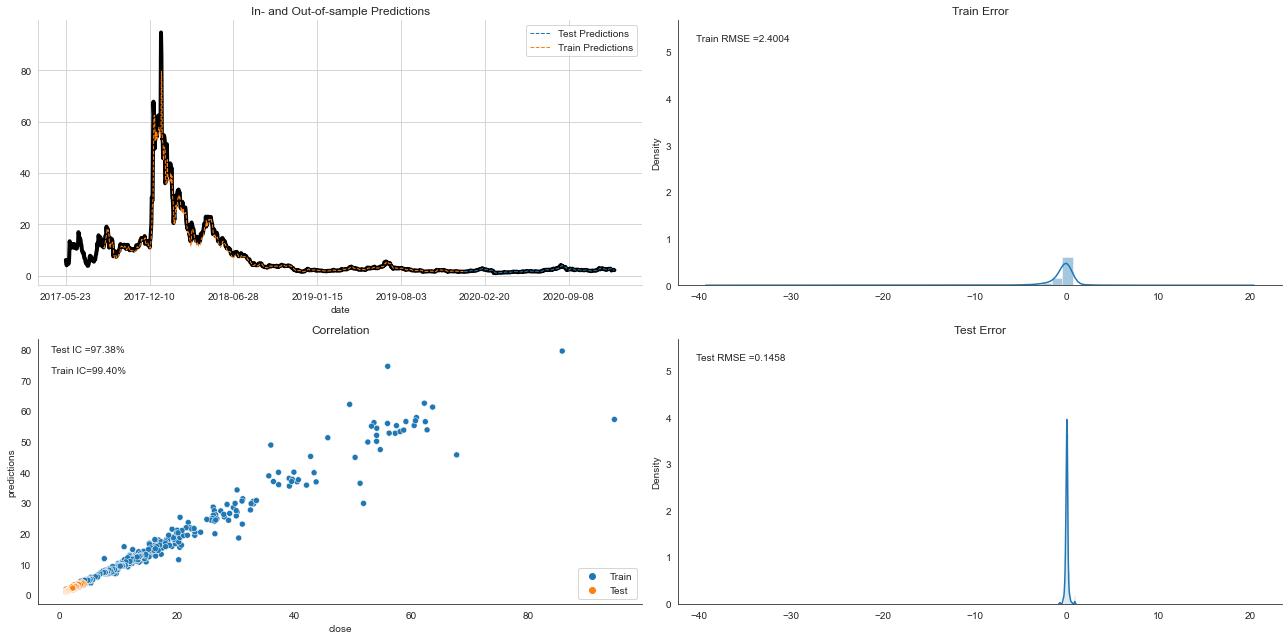

In [84]:
fig=plt.figure(figsize=(18,9))
ax1 = plt.subplot(221)

dfclose.loc['2017':, 'close'].plot(lw=4, ax=ax1, c='k')
dfclose.loc['2017':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='close', y='predictions', data=dfclose, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
# fig.savefig(results_path / 'rnn_cc_regression', dpi=300);

In [85]:
model_test = dfclose.copy()
ar = np.log(model_test['close']/model_test['close'].shift()).fillna(0)
pr = np.log(model_test['predictions'] / model_test['close'].shift()).fillna(0)
tmp = ar*pr[-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.47


# Predicting Future Returns:

# Preprocessing

In [86]:
scaler = MinMaxScaler()
dfreturn_scaled = pd.Series(scaler.fit_transform(dfreturn).squeeze(),index =dfreturn.index)
dfreturn_scaled.describe()

count    1309.000000
mean        0.508504
std         0.067504
min         0.000000
25%         0.482511
50%         0.508543
75%         0.535973
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

In [87]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [88]:
window_size = 90

In [89]:
X,y = create_univariate_rnn_data(dfreturn_scaled, window_size)

In [90]:
X.shape

(1219, 90)

# Train-test split

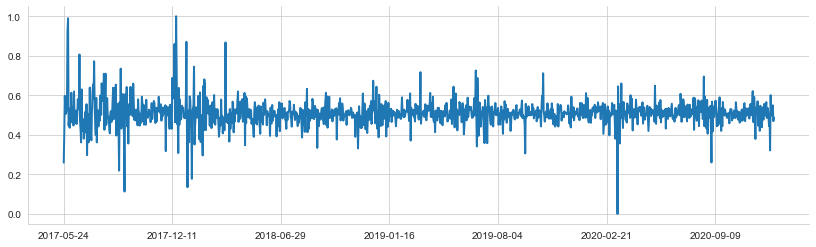

In [91]:
ax = dfreturn_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [92]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [93]:
n_obs, window_size, n_features = X_train.shape

In [94]:
y_train.shape

(859,)

# Define Model Architechture

In [95]:
rnn_return = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [96]:
rnn_return.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [97]:
rnn_return.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [98]:
lstm_training_return = rnn_return.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
43/43 [==============================] - 3s 22ms/step - loss: 0.2691 - val_loss: 0.0034

Epoch 00001: val_loss did not improve from 0.00000
Epoch 2/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0045 - val_loss: 0.0029

Epoch 00002: val_loss did not improve from 0.00000
Epoch 3/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0043 - val_loss: 0.0030

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0049 - val_loss: 0.0031

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0052 - val_loss: 0.0033

Epoch 00005: val_loss did not improve from 0.00000
Epoch 6/150
43/43 [==============================] - 1s 12ms/step - loss: 0.0051 - val_loss: 0.0030

Epoch 00006: val_loss did not improve from 0.00000
Epoch 7/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0047 - val_l


Epoch 00054: val_loss did not improve from 0.00000
Epoch 55/150
43/43 [==============================] - 0s 11ms/step - loss: 0.0046 - val_loss: 0.0029

Epoch 00055: val_loss did not improve from 0.00000


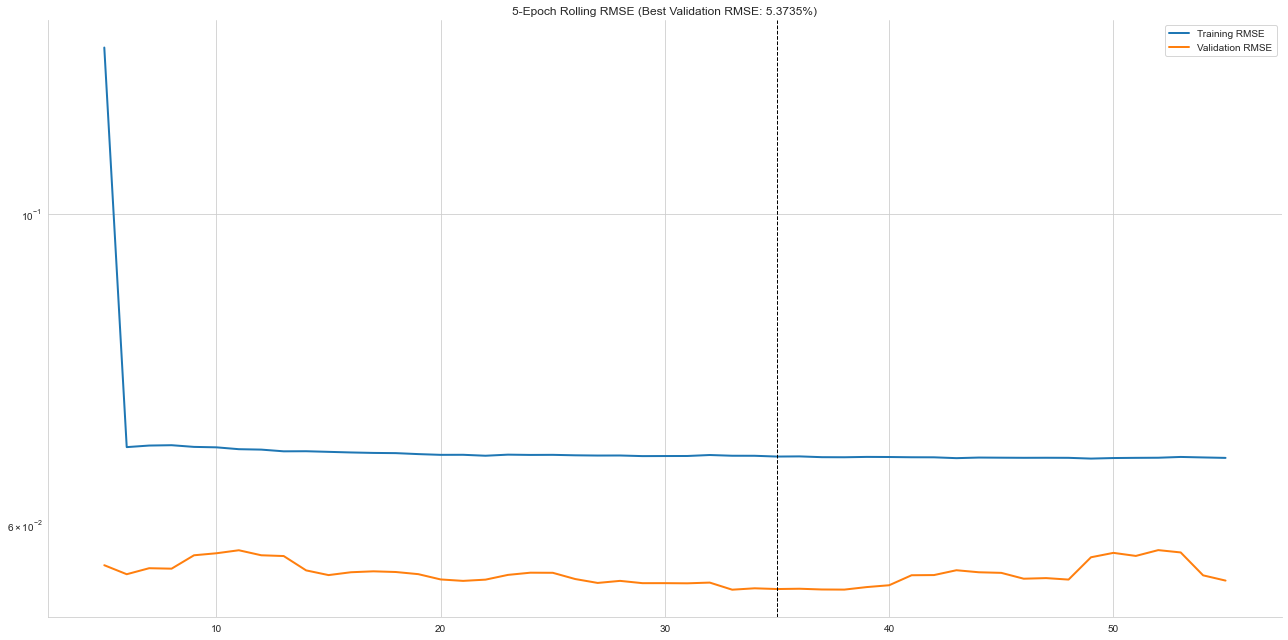

In [99]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_return.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [100]:
train_rmse_scaled = np.sqrt(rnn_return.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_return.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0662 | Test RMSE: 0.0537


In [101]:
train_predict_scaled = rnn_return.predict(X_train)
test_predict_scaled = rnn_return.predict(X_test)

In [102]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.0123 | Test IC: -0.0195


# Rescale predictions

In [103]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [104]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [105]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 0.08 | Test RMSE: 0.06'

In [106]:
dfreturn['Train Predictions'] = train_predict
dfreturn['Test Predictions'] = test_predict
dfreturn = dfreturn.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [107]:
dfreturn

,return,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-05-24,-0.284731,NaN,NaN,NaN,NaN
2017-05-25,-0.127354,NaN,NaN,NaN,NaN
2017-05-26,0.100592,NaN,NaN,NaN,NaN
2017-05-27,0.019259,NaN,NaN,NaN,NaN
2017-05-28,-0.003694,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,-0.013039,NaN,-0.002400,-0.002400,Test
2020-12-27,0.004028,NaN,-0.003209,-0.003209,Test
2020-12-28,0.045649,NaN,-0.003341,-0.003341,Test


In [108]:
model_test = dfreturn.copy().fillna(0)
tmp = model_test['return']*model_test['predictions'][-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.40
